# **Homework 2: Mining Time Series - do the top 5 countries with the most cumulative COVID-19 cases demonstrate similar patterns?**

In [204]:
import math
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib as plt
import statsmodels as stats
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from google.colab import files as colab_files
uploaded = colab_files.upload()

Saving time_series_covid19_confirmed_global.csv to time_series_covid19_confirmed_global (10).csv


# **Problem 1: Load & Transform the Data**

In [205]:
def load_data(file):
  df = pd.read_csv(file).set_index('Country/Region')
  df = df.filter(regex=r"[0-9]+/[0-9]+/[0-9]+", axis="columns")
  df.index.name = None
  top5Nations = df.loc[df['8/21/20'].sort_values(ascending=False)[:5].index].T
  top5Nations.index = pd.to_datetime(top5Nations.index, infer_datetime_format=True)
  top5Daily = top5Nations.diff()
  top5Daily.dropna(inplace=True)
  return top5Daily

top5Info = load_data('time_series_covid19_confirmed_global.csv')

Text(0, 0.5, 'The Number of the Cases')

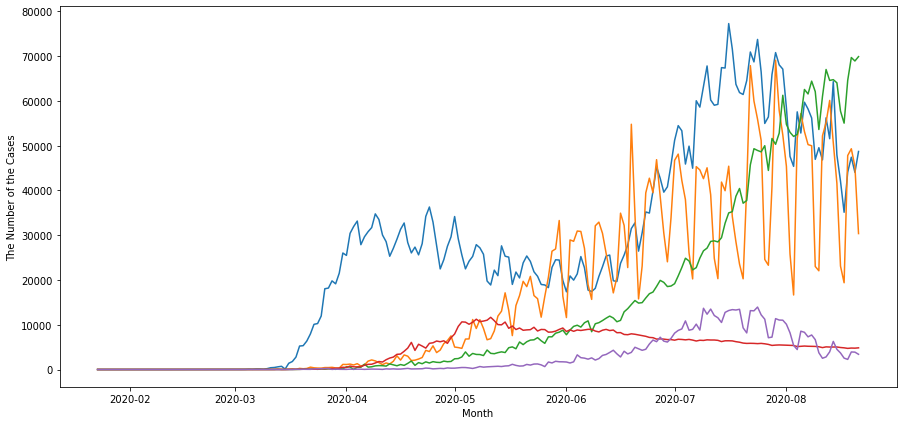

In [206]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(top5Info)
ax.set_xlabel("Month")
ax.set_ylabel("The Number of the Cases")

# **Problem 2: Extract Seasonal Components**

**Part #a:**

In [207]:
def decomposeSeasonal(df):
  result = pd.DataFrame()
  for column in df.columns:
    result = pd.concat([pd.DataFrame({column: seasonal_decompose(df[column], model='additive').seasonal}), result], axis=1)
  return result
seasonalInfo = decomposeSeasonal(top5Info)
seasonalInfo = seasonalInfo[seasonalInfo.columns[::-1]]
seasonalInfo

,US,Brazil,India,Russia,South Africa
2020-01-23,2431.761670,3380.626554,441.179428,-54.886371,322.986535
2020-01-24,3446.796153,3457.641332,621.396176,23.689984,362.434811
2020-01-25,578.564626,586.665963,594.066127,55.034811,391.346141
2020-01-26,-2728.454422,-6031.950950,46.655454,137.908703,76.880131
2020-01-27,-3293.854422,-7144.674760,-1234.673118,1.842036,-507.496059
...,...,...,...,...,...
2020-08-17,-3293.854422,-7144.674760,-1234.673118,1.842036,-507.496059
2020-08-18,-719.521088,1549.577621,-544.749308,-28.929392,-662.877011
2020-08-19,284.707483,4202.114239,76.125240,-134.659770,16.725452
2020-08-20,2431.761670,3380.626554,441.179428,-54.886371,322.986535


**Part #b:**

Text(0.513, 0.95, 'Seasonal Component of Daily New COVID-19 Cases in The Top 5 Countries for Most Cumulative Cases')

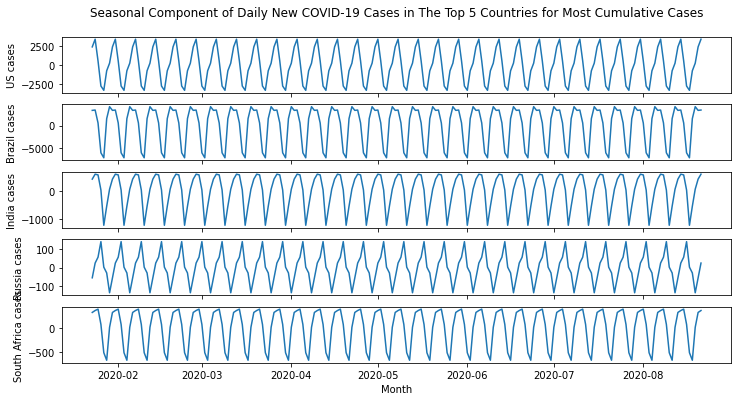

In [208]:
fig, axes = plt.subplots(len(seasonalInfo.columns), 1, figsize=(12, 6), sharex=True)
for i, col in enumerate(seasonalInfo.columns):
  axes[i].plot(seasonalInfo[col])
  axes[i].set_ylabel(col + ' cases')
axes[-1].set_xlabel('Month')
fig.suptitle('Seasonal Component of Daily New COVID-19 Cases in The Top 5 Countries for Most Cumulative Cases', x=0.513, y=0.95)

# **Problem 3: Time Series Similarities**

**3.1 Euclidean Distance**

**Part #a:**

In [209]:
def calc_euclidean_dist(df):
  cols = df.columns
  result = pd.DataFrame(0, index=cols, columns=cols)
  for firstIdx in range(len(cols)):
      for nextIdx in range(firstIdx+1, len(cols)):
        nationDiffMatrix = df[cols[firstIdx]] - df[cols[nextIdx]]
        nationSquareMatrix = np.square(df[cols[firstIdx]] - df[cols[nextIdx]])
        colSumMatrix = np.sum(nationSquareMatrix)
        result.loc[cols[firstIdx], cols[nextIdx]] = np.sqrt(colSumMatrix)
  result += result.T
  return result

**Part #b:**

In [210]:
calc_euclidean_dist(top5Info)

,US,Brazil,India,Russia,South Africa
US,0.000000,233760.757213,272344.138927,433638.331574,436238.175972
Brazil,233760.757213,0.000000,178779.663740,306032.283923,304919.698741
India,272344.138927,178779.663740,0.000000,316862.767630,303936.538967
Russia,433638.331574,306032.283923,316862.767630,0.000000,67392.593681
South Africa,436238.175972,304919.698741,303936.538967,67392.593681,0.000000


In [211]:
calc_euclidean_dist(seasonalInfo)

,US,Brazil,India,Russia,South Africa
US,0.000000,37616.752035,27032.887714,33986.305519,30084.544171
Brazil,37616.752035,0.000000,57583.437987,63663.896821,60839.376478
India,27032.887714,57583.437987,0.000000,9102.412727,4490.020448
Russia,33986.305519,63663.896821,9102.412727,0.000000,5658.222387
South Africa,30084.544171,60839.376478,4490.020448,5658.222387,0.000000


**3.2 Cosine Similarity**

**Part #a:**

In [212]:
def calc_cos_sim(df):
    cols = df.columns
    result = pd.DataFrame(0, index=cols, columns=cols)
    for idx1 in range(len(cols)):
        for idx2 in range(0, len(cols)):
            result.loc[cols[idx1], cols[idx2]] = np.sum(df[cols[idx1]]*df[cols[idx2]]) / (norm(df[cols[idx1]])*norm(df[cols[idx2]]))
 
    return result

**Part #b:**

In [213]:
calc_cos_sim(top5Info)

,US,Brazil,India,Russia,South Africa
US,1.000000,0.898664,0.847160,0.804740,0.884909
Brazil,0.898664,1.000000,0.878452,0.763523,0.871214
India,0.847160,0.878452,1.000000,0.590388,0.809944
Russia,0.804740,0.763523,0.590388,1.000000,0.638246
South Africa,0.884909,0.871214,0.809944,0.638246,1.000000


# **Problem 4: Dynamic Time Warping (DTW) Cost**

**4.1 Define a Function to Calculate DTW Cost**

**Part #a:**

In [214]:
def calc_pairwise_dtw_cost(series1, series2, ret_matrix=True):
    dtw = np.zeros((len(series2) + 1, len(series2) + 1))
    for i in range(len(series2) + 1):
        for j in range(len(series1) + 1):
            dtw[i, j] = np.inf
    dtw[0, 0] = 0

    for i in range(1, len(series2) + 1):
        for j in range(1, len(series1) + 1):
            cost = np.sum(np.square(series2[i-1] - series1[j-1]))
            dtw[i, j] = cost + np.min([dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1]])
    if ret_matrix:
        return dtw[1:, 1:]
    
    return dtw[len(series2), len(series1)]

**4.2 Compute Pairwise DTW Cost**

**Part #a:**

In [215]:
def calc_dtw_cost(df):
  cols = df.columns
  result = pd.DataFrame(0, index=cols, columns=cols)
  for firstIdx in range(len(cols)):
    for nextIdx in range(firstIdx+1, len(cols)):
      result.loc[cols[firstIdx], cols[nextIdx]] = calc_pairwise_dtw_cost(df[cols[firstIdx]], df[cols[nextIdx]], False)
  result += result.T
  np.fill_diagonal(result.values, 0)
  return result

In [216]:
calc_dtw_cost(top5Info)

,US,Brazil,India,Russia,South Africa
US,0,9575974038,5187397134,174074662446,139515939601
Brazil,9575974038,0,14309884215,83618108875,65427030728
India,5187397134,14309884215,0,99276257414,87289503477
Russia,174074662446,83618108875,99276257414,0,163867116
South Africa,139515939601,65427030728,87289503477,163867116,0


**Part #b:**

In [217]:
np.sqrt(calc_dtw_cost(seasonalInfo))

,US,Brazil,India,Russia,South Africa
US,0.000000,31878.178988,23565.948799,32327.414867,28016.515162
Brazil,31878.178988,0.000000,53400.789074,61868.013722,57143.198022
India,23565.948799,53400.789074,0.000000,7687.627537,4463.425362
Russia,32327.414867,61868.013722,7687.627537,0.000000,4259.096369
South Africa,28016.515162,57143.198022,4463.425362,4259.096369,0.000000


In [218]:
# The similarities among these seasonal patterns aren't so obvious, whereas there exists few similar such as theb seasonal pattern between India and South Africa. 
# The results of the pairwise Euclidean Distance and DTW Cost calculations indicates the same notice here, but they differ in Cosine Similarity. Both the Euclidean 
# Distance and the DTW Cost of seasonal patterns between US and Brazil ain't gentle, while cosine similarity of US and Brazil in seasonal patterns is relatively large.